In [1]:
import os
import cv2
import numpy as np
import time, os, sys
import json
import pandas as pd
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl

from urllib.parse import urlparse
from sklearn.neighbors import kneighbors_graph
from scipy.linalg import lstsq
from scipy.spatial import distance
from skimage.measure import find_contours
from skimage.morphology import disk, dilation
from scipy.ndimage.morphology import binary_dilation
from scipy.spatial.distance import cdist

%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
from cellpose import models, core
from cellpose import utils
from PIL import Image, ImageOps


use_GPU = core.use_gpu()
# print('>>> GPU activated? %d'%use_GPU)

# # call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
logger_setup();

files = ['../test_data/test_imgs_multi_with_nuclei/23/0701_reg001_cyc002_ch001_DAPI.png']

#imgs = [skimage.io.imread(f) for f in files]
# imgs = [np.asarray(Image.open(f)) for f in files]
imgs = [cv2.imread('../test_data/test_imgs_multi_with_nuclei/23/0701_reg001_cyc002_ch001_DAPI.png',1)]

print("img.shape = ",imgs[0].shape)

nimg = len(imgs)

model = models.CellposeModel(gpu=use_GPU, model_type='cyto',nchan = 2)

channels = [[0,0,0]]

#masks, flows, styles, diams = model.eval(imgs, diameter=None, flow_threshold=None, channels=channels)
masks, flows, styles = model.eval(imgs[0], diameter=None, flow_threshold=None,\
                                   tile = False, net_avg = True, mask_threshold = 0)

#masks = [_masks.astype('int32') for _masks in masks]

2022-03-02 21:46:44,209 [INFO] WRITING LOG OUTPUT TO /home/master/09/chacotw/.cellpose/run.log
img.shape =  (756, 672, 3)
2022-03-02 21:46:44,225 [INFO] >>cyto<< model set to be used
2022-03-02 21:46:44,258 [INFO] ** TORCH CUDA version installed and working. **
2022-03-02 21:46:44,263 [INFO] >>>> using GPU
self.net = CPnet!
nclasses =  3
nbase =  [2, 32, 64, 128, 256]
nchan =  2
nbase up =  [32, 64, 128, 256, 256]
2022-03-02 21:46:44,363 [WARNING] WARNING: more than 2 channels given, use "channels" input for specifying channels - just using first 2 channels to run processing


/home/master/09/chacotw/miniconda3/envs/unet/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


yf.shape =  (756, 672, 3)
yf =  [[[ 1.4209208e+00  1.4136623e+00 -2.3663828e-01]
  [ 2.6163316e+00  1.9109833e+00  8.3495665e-01]
  [ 3.2891531e+00  1.7768195e+00  1.3911375e+00]
  ...
  [ 3.9561691e+00 -5.1442188e-01  1.6788392e+00]
  [ 3.4256089e+00 -1.4020237e+00  1.4391383e+00]
  [ 2.0958045e+00 -1.5052358e+00  3.7603939e-01]]

 [[ 1.6984639e+00  2.6706347e+00  8.1604433e-01]
  [ 2.8601546e+00  3.1269722e+00  1.9281819e+00]
  [ 3.4540143e+00  2.8521554e+00  2.6640429e+00]
  ...
  [ 4.3683739e+00 -6.8634105e-01  2.7868357e+00]
  [ 3.7780268e+00 -1.9772050e+00  2.4068356e+00]
  [ 2.4108541e+00 -2.3515987e+00  1.1523839e+00]]

 [[ 1.4711188e+00  3.3468273e+00  1.1818142e+00]
  [ 2.4681756e+00  3.7769158e+00  2.4748080e+00]
  [ 3.0066240e+00  3.5373838e+00  3.4207544e+00]
  ...
  [ 4.3599110e+00 -8.0281013e-01  3.2189734e+00]
  [ 3.6783371e+00 -2.2604942e+00  2.7588687e+00]
  [ 2.2982183e+00 -2.7792401e+00  1.4508107e+00]]

 ...

 [[-8.3783641e-04 -1.9647628e-03 -6.7582054e+00]
  [-4.1

In [6]:
masks.shape

(756, 672)

In [7]:
cv2.imwrite("QQQQQ.png",masks*255)

True

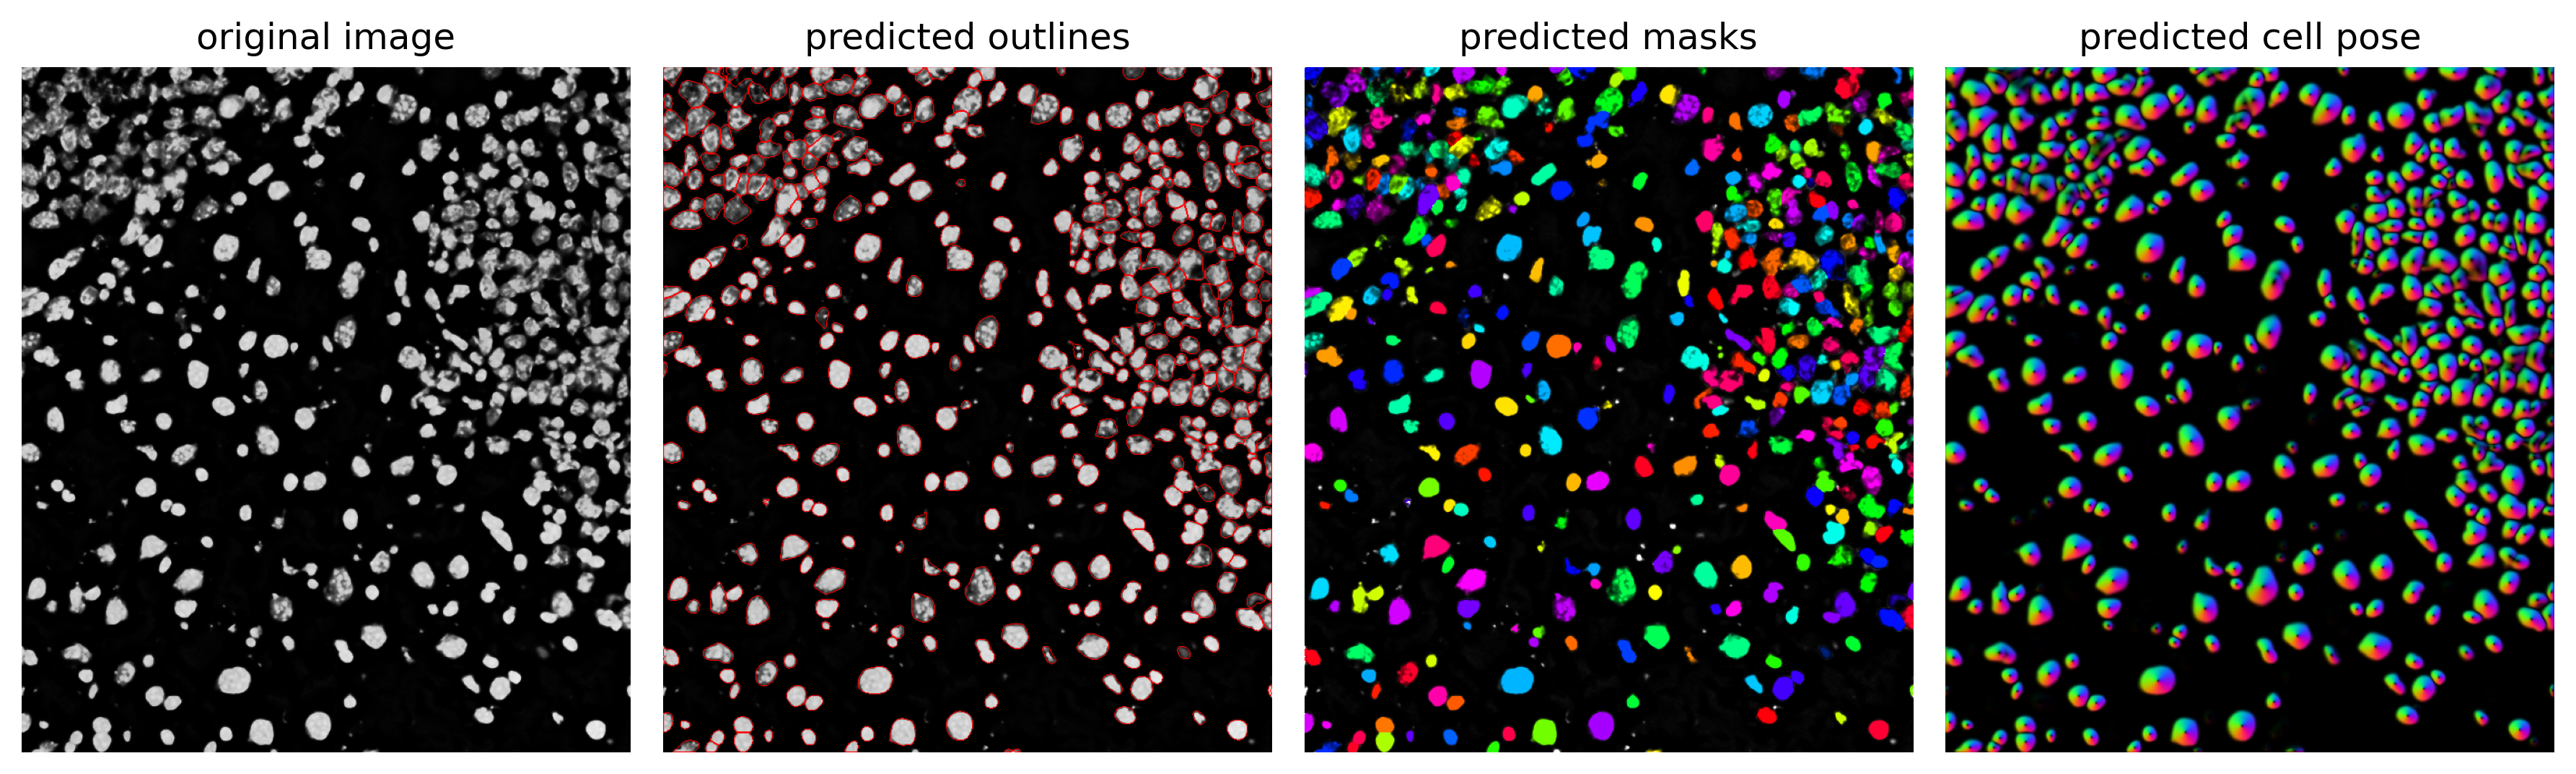

In [29]:
# DISPLAY RESULTS
from cellpose import plot

nimg = len(imgs)
for idx in range(nimg):
    maski = masks
    flowi = flows[0]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels[idx])
    plt.tight_layout()
    plt.show()

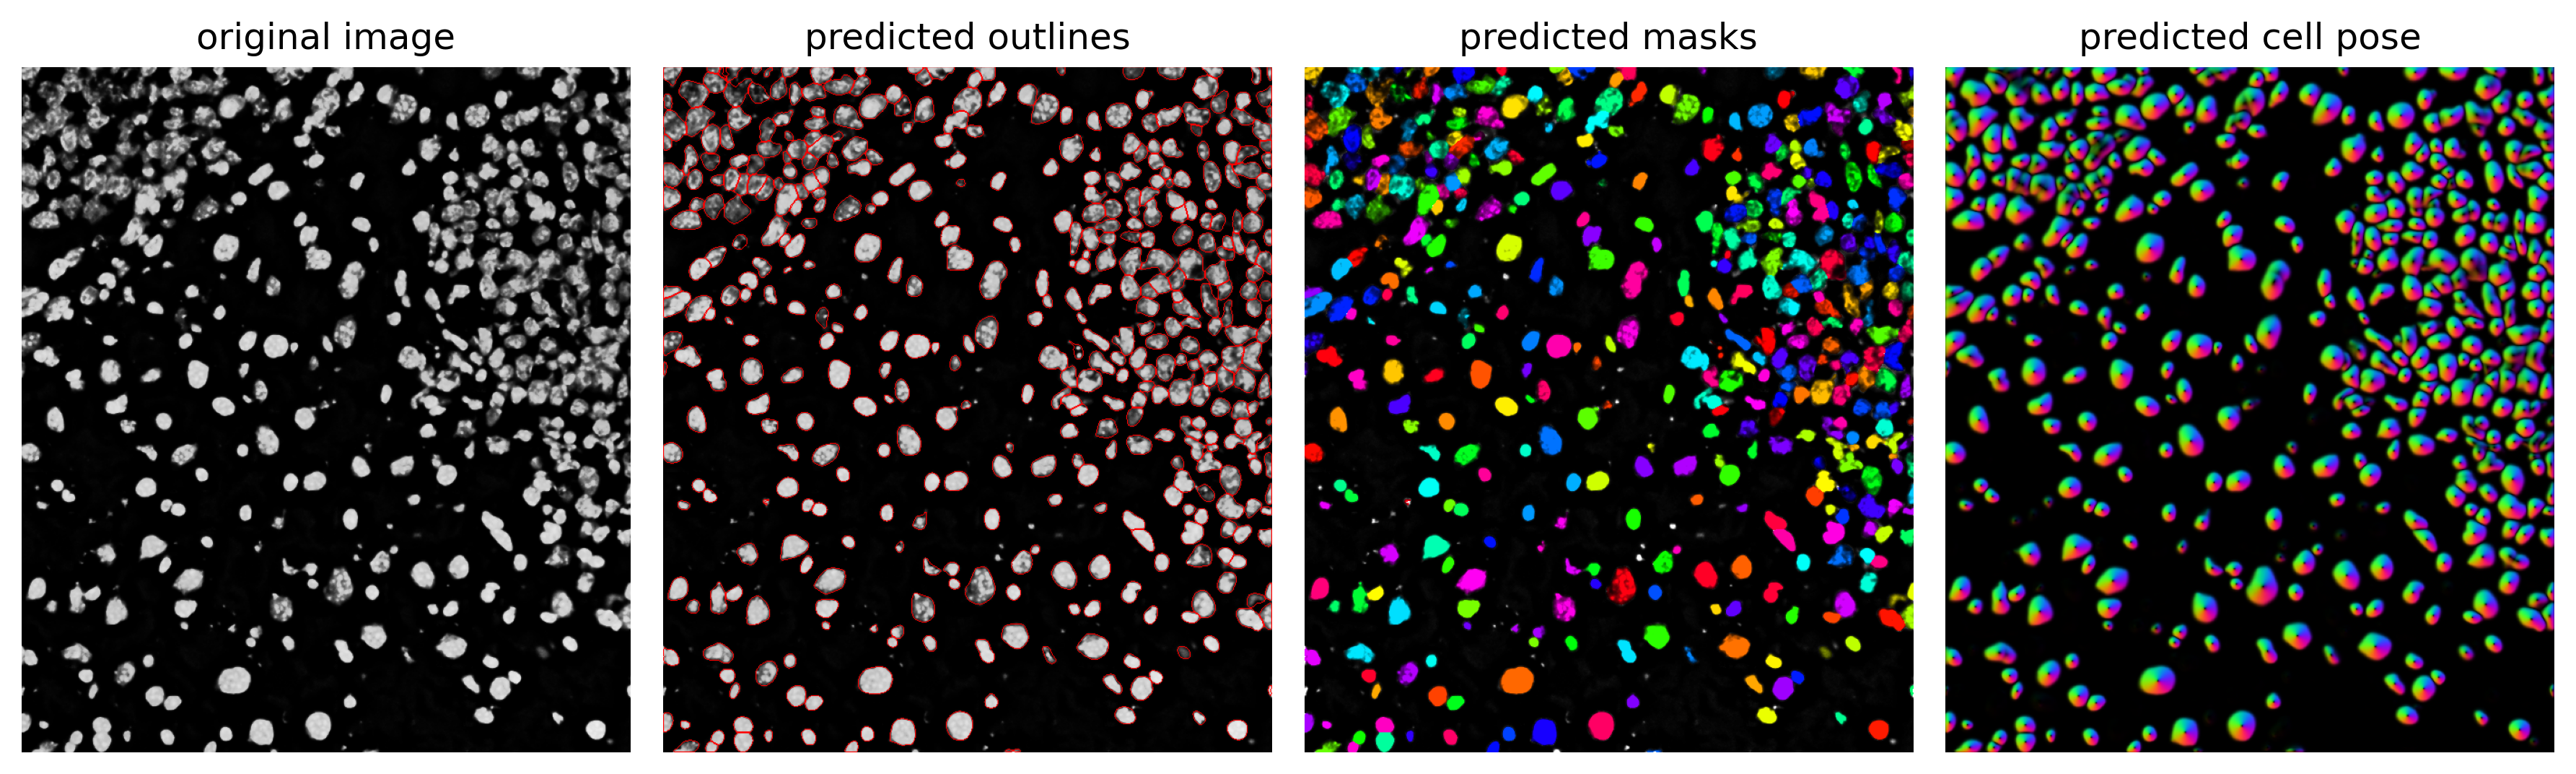

In [3]:
# DISPLAY RESULTS
from cellpose import plot

nimg = len(imgs)
for idx in range(nimg):
    maski = masks
    flowi = flows[0]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels[idx])
    plt.tight_layout()
    plt.show()

In [5]:
masks[0].shape

(756, 672)

In [81]:
def grow_masks(masks,growth, num_neighbors = 30):

    num_masks = len(np.unique(masks)) - 1
    
    bb_mins, bb_maxes = compute_boundbox(masks)

    print("Sequential growth selected")
    Y, X = masks.shape
    struc = disk(1)
    for _ in range(growth):
        for i in range(num_masks):
            mins = bb_mins[i]
            maxes = bb_maxes[i]
            minY, minX, maxY, maxX = mins[0] - 3*growth, mins[1] - 3*growth, maxes[0] + 3*growth, maxes[1] + 3*growth
            if minX < 0: minX = 0
            if minY < 0: minY = 0
            if maxX >= X: maxX = X - 1
            if maxY >= Y: maxY = Y - 1

            currreg = masks[minY:maxY, minX:maxX]
            mask_snippet = (currreg == i + 1)
            full_snippet = currreg > 0
            other_masks_snippet = full_snippet ^ mask_snippet ## ^ = XOR 
            dilated_mask = binary_dilation(mask_snippet, struc)
            final_update = (dilated_mask ^ full_snippet) ^ other_masks_snippet

            # f, axarr = plt.subplots(1, 5)
            # plt.imshow(mask_snippet)
            # axarr[0].imshow(mask_snippet)
            # axarr[1].imshow(full_snippet)
            # axarr[2].imshow(other_masks_snippet)
            # axarr[3].imshow(dilated_mask)
            # axarr[4].imshow(final_update)
            # plt.show()

            pix_to_update = np.nonzero(final_update)

            pix_X = np.array([min(j + minX, X) for j in pix_to_update[1]])
            pix_Y = np.array([min(j + minY, Y) for j in pix_to_update[0]])

            masks[pix_Y, pix_X] = i + 1

    return masks


In [82]:
def compute_boundbox(masks):
    
    num_masks = len(np.unique(masks)) - 1
    indices = np.where(masks != 0)
    values = masks[indices[0], indices[1]]

    maskframe = pd.DataFrame(np.transpose(np.array([indices[0], indices[1], values]))).rename(columns = {0:"y", 1:"x", 2:"id"})
    bb_mins = maskframe.groupby('id').agg({'y': 'min', 'x': 'min'}).to_records(index = False).tolist()
    bb_maxes = maskframe.groupby('id').agg({'y': 'max', 'x': 'max'}).to_records(index = False).tolist()
    
    return bb_mins, bb_maxes

In [84]:
#cents, growed_masks = grow_masks(masks, growth = 15, num_neighbors = 30)
growed_masks = grow_masks(masks[0], growth = 0, num_neighbors = 30)

Sequential growth selected


In [31]:
import colorsys
import random
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    colors = [(int(i[0] * 255), int(i[1] * 255), int(i[2] * 255)) for i in colors]
    random.shuffle(colors)
    return colors
    

In [85]:
# growed_masks.dtype
cv2.imwrite("WTF15.png",growed_masks)#.astype('uint8')
# final_masks = np.max(growed_masks, axis = 2).astype('uint8')

True

In [86]:
def geojson_format(coords):
    
    geojson_list = []
    for coord in coords:
        coord = np.squeeze(coord).tolist()
        geojson = {
        "type": "Feature",
        "id": "PathAnnotationObject",
        "geometry": {
          "type": "Polygon",
          "coordinates": [coord]
        },
        "properties": {
          "isLocked": False,
          "measurements": []
        }
      }
        
        geojson_list.append(geojson)
    
    return geojson_list

In [35]:
len(np.unique(growed_masks))

486

In [87]:
res = []
blank = np.zeros((756, 672,3))

colors = random_colors(len(np.unique(growed_masks)))

for i in range(1,len(np.unique(growed_masks)) - 1):
    _mask = np.array((growed_masks == i)*255, dtype = "uint8")
    
#     ### for fuse
#     tmp = cv2.bitwise_and(_mask,post_processing_img_255)
    
#     if not np.any(tmp>0):

#     ###
    checked_cnts = []
    contours,hierarchy = cv2.findContours(_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    for cnt in contours:
        mask_area = cv2.contourArea(cnt)

        if mask_area > 50:
            checked_cnts.append(cnt)
        else:
            print("No. {} less than 50".format(i), mask_area)
    cv2.drawContours(blank, checked_cnts , -1, colors[i])

    res.extend(checked_cnts)

No. 18 less than 50 12.5
No. 39 less than 50 19.5
No. 44 less than 50 0.0
No. 96 less than 50 35.0
No. 109 less than 50 46.0
No. 132 less than 50 29.5
No. 218 less than 50 37.0
No. 292 less than 50 39.5
No. 296 less than 50 26.0
No. 298 less than 50 8.0
No. 332 less than 50 38.5
No. 396 less than 50 42.0
No. 464 less than 50 45.5
No. 466 less than 50 21.5


In [ ]:
# final = geojson_format(res)
# img_name = "full_img_cnts_5"
# with open("./{}.json".format(img_name), 'w', encoding='utf-8') as f:
#     json.dump(final, f, ensure_ascii=False, indent=4)

In [88]:
cv2.imwrite("cnt5152.png",blank)

True

In [38]:
import cv2

In [62]:
post_processing_img = cv2.imread('../Label Image.png',0)

In [63]:
post_processing_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [64]:
post_processing_img_255 = ((post_processing_img>0)*255).astype('uint8')

In [67]:
post_processing_img_255

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [66]:
cv2.imwrite('../QQ.png',post_processing_img_255)

True

In [68]:
post_processing_img_255.shape

(756, 672)

In [74]:
colors = random_colors(1500)
for i in range(1,256):

    _mask = np.array((post_processing_img == i)*255, dtype = "uint8")
    

    checked_cnts = []
    contours,hierarchy = cv2.findContours(_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    for cnt in contours:
        mask_area = cv2.contourArea(cnt)

        if mask_area > 10:
            checked_cnts.append(cnt)
        else:
            print("No. {} less than 10".format(i), mask_area)
    cv2.drawContours(blank, checked_cnts , -1, colors[i])

    res.extend(checked_cnts)
    

No. 106 less than 10 6.5
No. 106 less than 10 0.0
No. 106 less than 10 0.0
No. 106 less than 10 0.0
No. 106 less than 10 0.0
No. 138 less than 10 3.0
No. 147 less than 10 0.0
No. 149 less than 10 5.0
No. 168 less than 10 0.0
No. 181 less than 10 4.0
No. 199 less than 10 0.0
No. 199 less than 10 1.0


In [29]:
files = ['../test_data/test_imgs_multi_with_nuclei/23/0701_reg001_cyc002_ch001_DAPI.png']

#imgs = [skimage.io.imread(f) for f in files]
imgs = [np.asarray(Image.open(f)) for f in files]

In [15]:
from cellpose import transforms
from cellpose import dynamics, io, plot, utils
import numpy as np
from scipy.ndimage import label

In [16]:
train_datas = io.imread('../test_data/test_imgs_multi_with_nuclei/23/0701_reg001_cyc002_ch001_DAPI.png')#imgs[0]
train_labels = np.load("../train_data/multi_refined_same_ch_wo23/masks/13_mask.npy")
train_labels, num_features = label(train_labels)

In [17]:
train_labels.max()

577

In [18]:
train_datas.shape

(756, 672)

In [19]:
train_data, train_label, _, _, _ = transforms.reshape_train_test([train_datas], [train_labels], None , None ,None, None, None)

In [20]:
train_label[0].dtype

dtype('int32')

In [21]:
labels_to_flows = dynamics.labels_to_flows

In [22]:
train_flows = labels_to_flows(train_label, files=None, use_gpu=None, device=None)


2022-03-02 01:45:01,208 [INFO] computing flows for labels


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


In [23]:
train_flows[0].shape

(4, 756, 672)

In [24]:
flow2 = plot.dx_to_circ([train_flows[0][1], train_flows[0][1]])

IndexError: index 4 is out of bounds for axis 0 with size 4

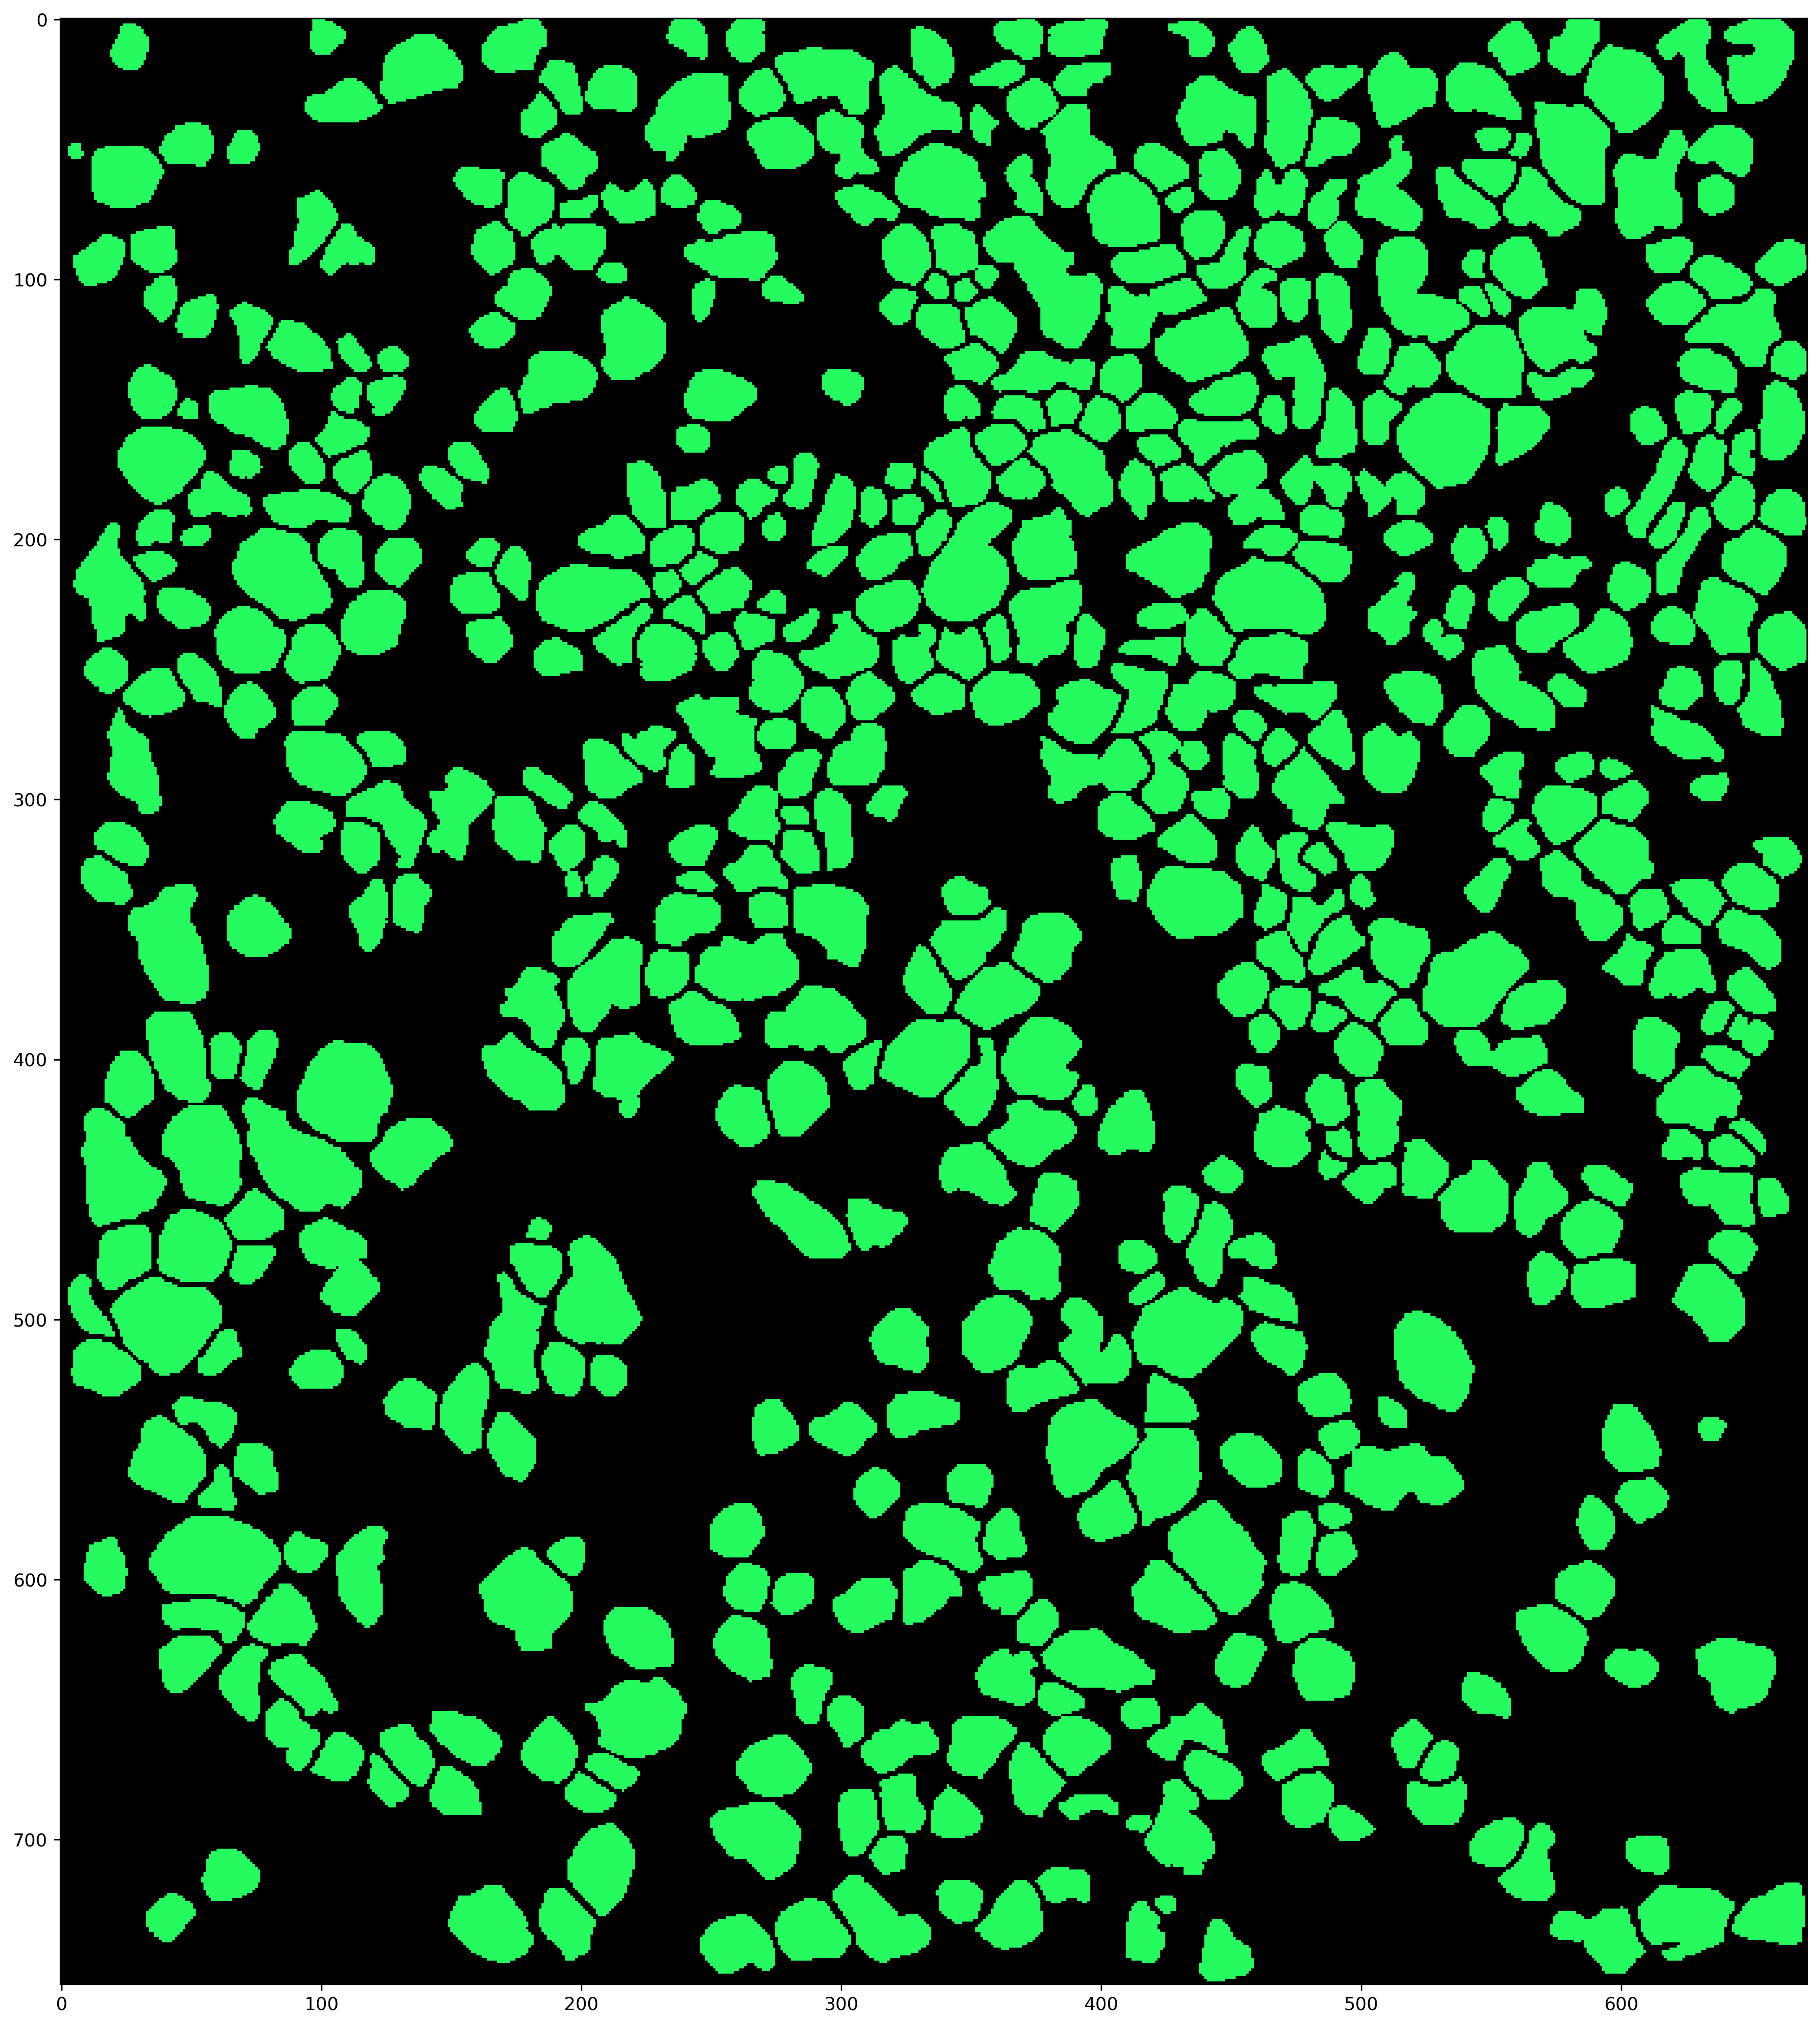

In [25]:
plt.figure(figsize=(20,20))
plt.imshow(flow2)
plt.show()

In [16]:
imgi, lbl , _= transforms.random_rotate_and_resize(train_data, train_flows, unet=False)

In [17]:
imgi.shape

(1, 1, 224, 224)

In [18]:
lbl.shape

(1, 3, 224, 224)

In [19]:
lbl[:,1:].shape

(1, 2, 224, 224)

In [21]:
lbl.min()

-0.9998669